In [18]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
from pyentrp import entropy as pyent
import EntropyHub as EH
import neurokit2 as nk
import random
import sampen
import requests
import io
from pprint import pprint
import os
from sklearn import preprocessing
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.flux_table import FluxTable
import datetime
from typing import List
import itertools
import datetime
import itertools
import math
import apache_log_parser
from datetime import datetime

In [4]:


line_parser = apache_log_parser.make_parser("%h %l %u %t \"%r\"")
test_data ='204.249.225.59 - - [28/Aug/1995:00:00:34 -0400] "GET /pub/rmharris/catalogs/dawsocat/intro.html HTTP/1.0" 200 3542'
log_line_data = line_parser(test_data)
pprint(log_line_data)

{'remote_host': '204.249.225.59',
 'remote_logname': '-',
 'remote_user': '-',
 'request_first_line': 'GET /pub/rmharris/catalogs/dawsocat/intro.html '
                       'HTTP/1.0',
 'request_http_ver': '1.0',
 'request_method': 'GET',
 'request_url': '/pub/rmharris/catalogs/dawsocat/intro.html',
 'request_url_fragment': '',
 'request_url_hostname': None,
 'request_url_netloc': '',
 'request_url_password': None,
 'request_url_path': '/pub/rmharris/catalogs/dawsocat/intro.html',
 'request_url_port': None,
 'request_url_query': '',
 'request_url_query_dict': {},
 'request_url_query_list': [],
 'request_url_query_simple_dict': {},
 'request_url_scheme': '',
 'request_url_username': None,
 'time_received': '[28/Aug/1995:00:00:34 -0400]',
 'time_received_datetimeobj': datetime.datetime(1995, 8, 28, 0, 0, 34),
 'time_received_isoformat': '1995-08-28T00:00:34',
 'time_received_tz_datetimeobj': datetime.datetime(1995, 8, 28, 0, 0, 34, tzinfo='0400'),
 'time_received_tz_isoformat': '1995-0

In [15]:
raw_df_S = pd.read_csv("clarknet_access_log_Aug28.csv").to_numpy()

In [16]:
raw_df_S

array([[0, '1995-08-28 00:00:34', 1],
       [1, '1995-08-28 00:00:35', 2],
       [2, '1995-08-28 00:00:36', 2],
       ...,
       [604704, '1995-09-03 23:58:58', 1],
       [604705, '1995-09-03 23:58:59', 4],
       [604706, '1995-09-03 23:59:00', 3]], dtype=object)

In [19]:

df_S = pd.DataFrame([{"date": datetime.fromisoformat(df[1]), "count": df[2]} for df in raw_df_S])
df_S

,date,count
0,1995-08-28 00:00:34,1
1,1995-08-28 00:00:35,2
2,1995-08-28 00:00:36,2
3,1995-08-28 00:00:37,2
4,1995-08-28 00:00:38,4
...,...,...
604702,1995-09-03 23:58:56,3
604703,1995-09-03 23:58:57,2
604704,1995-09-03 23:58:58,1
604705,1995-09-03 23:58:59,4


In [110]:

df_1M = df_S.groupby(pd.Grouper(key="date", freq="min")).sum().reset_index()
df_1M

,date,count
0,1995-08-28 00:00:00,44
1,1995-08-28 00:01:00,124
2,1995-08-28 00:02:00,166
3,1995-08-28 00:03:00,117
4,1995-08-28 00:04:00,182
...,...,...
10075,1995-09-03 23:55:00,154
10076,1995-09-03 23:56:00,220
10077,1995-09-03 23:57:00,168
10078,1995-09-03 23:58:00,151


In [22]:
df_M = df_S.groupby(pd.Grouper(key="date", freq="10min")).sum().reset_index()
df_M

,date,count
0,1995-08-28 00:00:00,1493
1,1995-08-28 00:10:00,1543
2,1995-08-28 00:20:00,1265
3,1995-08-28 00:30:00,1116
4,1995-08-28 00:40:00,1567
...,...,...
1003,1995-09-03 23:10:00,1407
1004,1995-09-03 23:20:00,1489
1005,1995-09-03 23:30:00,1558
1006,1995-09-03 23:40:00,1482


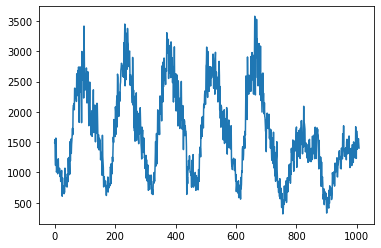

In [23]:
plt.plot(df_M["count"])

In [113]:
df_1M_count = df_1M["count"].rolling(6).max().array.reshape(-1, 1)
df_1M_date = df_1M["date"].array.reshape(-1, 1)

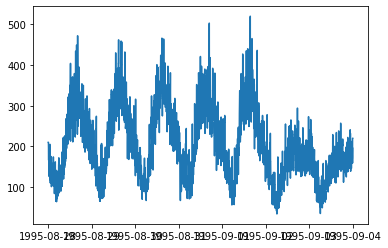

In [115]:
plt.plot(df_1M_date, df_1M_count)

In [ ]:
df_M_date = (pd.to_datetime(df_1M["count"].rolling(6).mean()).astype(int) / 10**9).array.reshape(-1, 1)
df_M_count = df_M["count"].array.reshape(-1, 1)

In [24]:
df_M_date = (pd.to_datetime(df_M["date"]).astype(int) / 10**9).array.reshape(-1, 1)
df_M_count = df_M["count"].array.reshape(-1, 1)

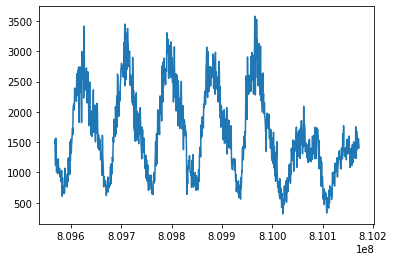

In [25]:
plt.plot(df_M_date, df_M_count)

In [72]:
def lr_loop(x, y, batch_size = 100, incr = 10):
    factors = []
    counter = batch_size
    while len(x) > counter:
        try:
            x_train = pd.Series(x[counter-batch_size:counter])
            y_train = pd.Series(y[counter-batch_size:counter])
            factor = x_train.corr(y_train)
            factors += [{"date": x[counter], "factor": factor}]
            counter += incr
        except Exception as e:
            print(e)
            counter += incr
    return pd.DataFrame(factors)

In [73]:
clark_lr = lr_loop(list(itertools.chain.from_iterable(df_M_date.tolist())), list(itertools.chain.from_iterable(df_M_count.tolist())))


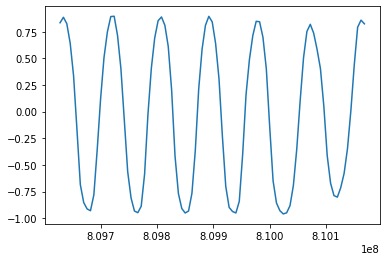

In [84]:
plt.plot(clark_lr["date"], clark_lr["factor"])

In [87]:
# def fuzzy_loop(ser: List[float], batch_size = 100) -> List[float]:
#     return [nk.entropy_fuzzy(np.array(ser[index-batch_size:index]))[0] for index in range(len(ser))[batch_size:]]

def fuzzy_loop(x, y, batch_size = 100, incr = 10):
    fs = []
    counter = batch_size
    while len(x) > counter:
        try:
            y_train = y[counter-batch_size:counter]
            f = nk.entropy_fuzzy(np.array(y_train))
            fs += [{"date": x[counter], "entropy": f[0]}]
            counter += incr
        except Exception as e:
            print(e)
            counter += incr
    return pd.DataFrame(fs)

In [88]:
clark_fuzzy = fuzzy_loop(list(itertools.chain.from_iterable(df_M_date.tolist())), list(itertools.chain.from_iterable(df_M_count.tolist())))

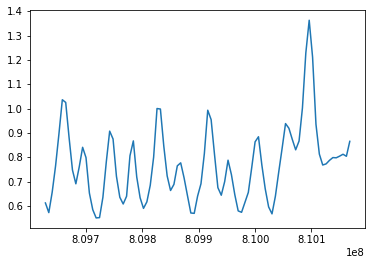

In [90]:
plt.plot(clark_fuzzy["date"], clark_fuzzy["entropy"])

In [100]:
def compute_enet( x_train, y_train, alpha = 1.0, l1_ratio = 0.5) -> ElasticNet:
    return ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(x_train, y_train)

In [98]:
def enet_loop(x, y, alpha = 1.0, l1_ratio = 0.5, batch_size = 300, incr = 30):
    y_pred = pd.DataFrame([])
    counter = batch_size
    while len(x) > counter:
        try:
            x_train = x[counter-batch_size:counter]
            y_train = y[counter-batch_size:counter]
            x_test = x[counter:counter+incr].reshape(-1, 1)
            enet = compute_enet(x_train, y_train, alpha, l1_ratio)
            target_y_pred = enet.predict(x_test)
            y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
            counter += incr
        except Exception as e:
            print(e)
            counter += incr
    return y_pred

In [101]:
df_M_pred = enet_loop(df_M_date, df_M_count)

/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_50071/407591904.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_50071/407591904.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_50071/407591904.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_50071/407591904.py:11: FutureWarning: The frame.append method is deprecated a

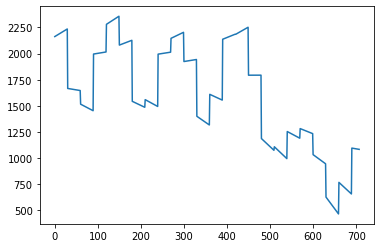

In [102]:
plt.plot(df_M_pred)

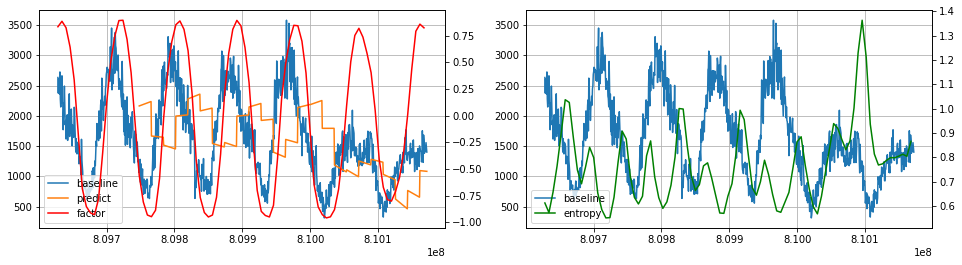

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
ln1 = axes[0].plot(df_M_date[100:], df_M_count[100:],label='baseline')
ln1 = axes[0].plot(df_M_date[300:], df_M_pred,label='predict')

ax1 = axes[0].twinx()
ln2 = ax1.plot(clark_lr["date"], clark_lr["factor"], color='red', label="factor")

h1, l1 = axes[0].get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
axes[0].legend(h1+h2, l1+l2, loc='lower left')

axes[0].grid(True)

ln3 = axes[1].plot(df_M_date[100:], df_M_count[100:],label='baseline')

ax2 = axes[1].twinx()
ln4 = ax2.plot(clark_fuzzy["date"], clark_fuzzy["entropy"], color='green', label="entropy")

h3, l3 = axes[1].get_legend_handles_labels()
h4, l4 = ax2.get_legend_handles_labels()
axes[1].legend(h3+h4, l3+l4, loc='lower left')

axes[1].grid(True)

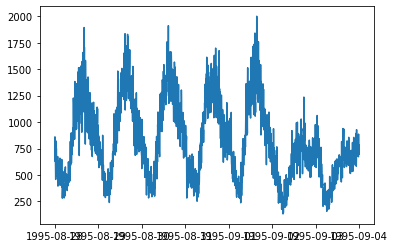

In [137]:
df_1M = df_S.groupby(pd.Grouper(key="date", freq="5min")).sum().reset_index()
df_1M
plt.plot(df_1M["date"], df_1M["count"])

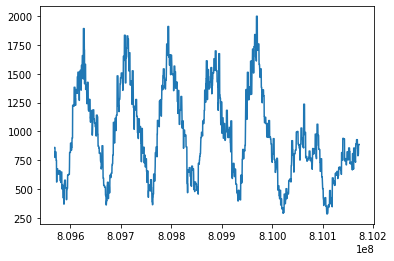

In [149]:
df_1M_count = df_1M["count"].rolling(6).max().array.reshape(-1, 1)
# df_1M_count = df_1M["count"].array.reshape(-1, 1)
df_1M_date = (pd.to_datetime(df_1M["date"]).astype(int) / 10**9).array.reshape(-1, 1)
plt.plot(df_1M_date, df_1M_count)

In [154]:
clark_lr_1M = lr_loop(list(itertools.chain.from_iterable(df_1M_date.tolist())), list(itertools.chain.from_iterable(df_1M_count.tolist())))
clark_lr_1M

,date,factor
0,809598000.0,-0.644374
1,809601000.0,-0.138190
2,809604000.0,0.395726
3,809607000.0,0.673278
4,809610000.0,0.833377
...,...,...
187,810159000.0,0.345127
188,810162000.0,0.108802
189,810165000.0,-0.005245
190,810168000.0,-0.120740


In [140]:
clark_fuzzy_1M = fuzzy_loop(list(itertools.chain.from_iterable(df_1M_date.tolist())), list(itertools.chain.from_iterable(df_1M_count.tolist())))
clark_fuzzy_1M

,date,entropy
0,809598000.0,1.240286
1,809601000.0,1.303468
2,809604000.0,1.140543
3,809607000.0,0.926322
4,809610000.0,0.792662
...,...,...
187,810159000.0,1.392961
188,810162000.0,1.543837
189,810165000.0,1.603945
190,810168000.0,1.613282


In [151]:
clark_enet_1M = enet_loop(df_1M_date, df_1M_count)
clark_enet_1M

Input y contains NaN.


/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_50071/407591904.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_50071/407591904.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_50071/407591904.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/zk/cf948rq56631k5dgzn62fkjm0000gn/T/ipykernel_50071/407591904.py:11: FutureWarning: The frame.append method is deprecated a

,0
0,1254.018027
1,1255.439409
2,1256.860791
3,1258.282173
4,1259.703556
...,...
1681,764.253932
1682,764.761945
1683,765.269958
1684,765.777971


In [152]:
len(df_1M_date), len(clark_enet_1M)

(2016, 1686)

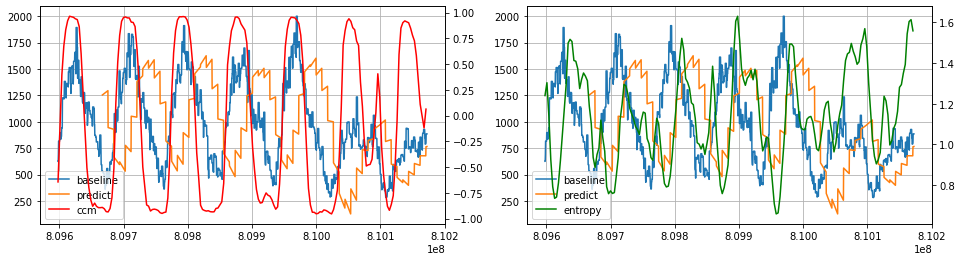

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
ln1 = axes[0].plot(df_1M_date[100:], df_1M_count[100:],label='baseline')
ln1 = axes[0].plot(df_1M_date[330:], clark_enet_1M,label='predict')

ax1 = axes[0].twinx()
ln2 = ax1.plot(clark_lr_1M["date"], clark_lr_1M["factor"], color='red', label="ccm")

h1, l1 = axes[0].get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()
axes[0].legend(h1+h2, l1+l2, loc='lower left')

axes[0].grid(True)

ln3 = axes[1].plot(df_1M_date[100:], df_1M_count[100:],label='baseline')

ax2 = axes[1].twinx()
ln4 = ax2.plot(clark_fuzzy_1M["date"], clark_fuzzy_1M["entropy"], color='green', label="entropy")
ln5 = axes[1].plot(df_1M_date[330:], clark_enet_1M,label='predict')

h3, l3 = axes[1].get_legend_handles_labels()
h4, l4 = ax2.get_legend_handles_labels()
axes[1].legend(h3+h4, l3+l4, loc='lower left')

axes[1].grid(True)